In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d, interp2d
import dask
import pandas as pd

In [23]:
# list of testing molecules
names = ['n-octane','ethanol','nitromethane','phenol','toluene','1,4-dioxane','acetone','aceticacid']

In [197]:
df = pd.read_csv('VASPsol_Data.csv')
df = df[df['SoluteName'].isin(names)]
df

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,OP,S,HS,OS,SP,SS,TotalArea,error,error_ev,error_frac
512,512,water,0008noc,0.002472,0.448381,0.000635,0.125520,-139.568960,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,-0.004491,-0.000195,-0.001554
513,513,water,0008noc,0.002442,0.465850,0.000624,0.121470,-139.573010,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,0.088902,0.003855,0.030762
514,514,water,0008noc,0.002517,0.419506,0.000655,0.132640,-139.561840,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,-0.168678,-0.007315,-0.058366
515,515,water,0008noc,0.002471,0.449172,0.000635,0.125330,-139.569150,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,-0.000110,-0.000005,-0.000038
516,516,water,0008noc,0.002491,0.450552,0.000632,0.124000,-139.570480,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,0.030560,0.001325,0.010574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8799,8799,water,0053phe,0.002626,0.638958,0.000483,-0.287089,-82.972285,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.000272,0.000012,-0.000041
8800,8800,water,0053phe,0.002626,0.639090,0.000483,-0.287114,-82.972310,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.000849,0.000037,-0.000128
8801,8801,water,0053phe,0.002649,0.632227,0.000485,-0.285222,-82.970418,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,-0.042781,-0.001855,0.006462
8802,8802,water,0053phe,0.002626,0.639287,0.000483,-0.287213,-82.972409,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.003132,0.000136,-0.000473


In [198]:
# make a scatter plot of the unique values of NC_K and SIGMA_K
grouped_df = df.groupby(['NC_K','SIGMA_K']).count()
grouped_df = grouped_df[grouped_df.values >= len(names)-2]

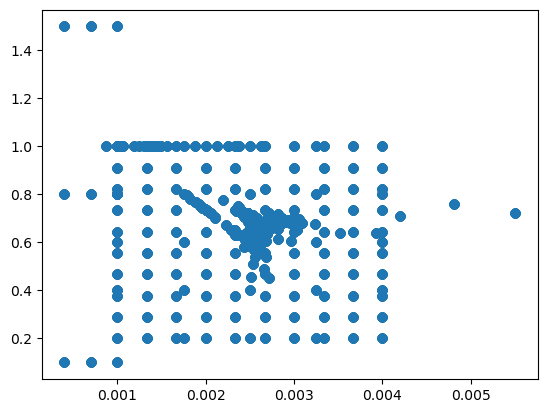

In [199]:
# x will be the unique nc_k values
x = grouped_df.index.get_level_values('NC_K').to_numpy()
y = grouped_df.index.get_level_values('SIGMA_K').to_numpy()
plt.scatter(x, y)

In [200]:
grid_nc = np.linspace(0.001, 0.004, 10)
grid_sigma = np.linspace(0.2, 1.0, 10)
# values not in the grid
opt_nc = [i for i in x if i not in grid_nc]
opt_sigma = [i for i in y if i not in grid_sigma]

In [201]:
# get all values in the grouped df with opt_nc or opt_sigma values
df2 = []
for i in range(df.shape[0]):
    if df.iloc[i]['NC_K']  not in opt_nc:
        if df.iloc[i]['SIGMA_K']  not in opt_sigma:
            df2.append(df.iloc[i])
            print(df.iloc[i])
df2

Unnamed: 0         512
Solvent          water
FileHandle     0008noc
NC_K          0.002472
SIGMA_K       0.448381
                ...   
SS                 0.0
TotalArea      243.846
error        -0.004491
error_ev     -0.000195
error_frac   -0.001554
Name: 512, Length: 67, dtype: object
Unnamed: 0         513
Solvent          water
FileHandle     0008noc
NC_K          0.002442
SIGMA_K        0.46585
                ...   
SS                 0.0
TotalArea      243.846
error         0.088902
error_ev      0.003855
error_frac    0.030762
Name: 513, Length: 67, dtype: object
Unnamed: 0         514
Solvent          water
FileHandle     0008noc
NC_K          0.002517
SIGMA_K       0.419506
                ...   
SS                 0.0
TotalArea      243.846
error        -0.168678
error_ev     -0.007315
error_frac   -0.058366
Name: 514, Length: 67, dtype: object
Unnamed: 0         515
Solvent          water
FileHandle     0008noc
NC_K          0.002471
SIGMA_K       0.449172
               

[Unnamed: 0         512
 Solvent          water
 FileHandle     0008noc
 NC_K          0.002472
 SIGMA_K       0.448381
                 ...   
 SS                 0.0
 TotalArea      243.846
 error        -0.004491
 error_ev     -0.000195
 error_frac   -0.001554
 Name: 512, Length: 67, dtype: object,
 Unnamed: 0         513
 Solvent          water
 FileHandle     0008noc
 NC_K          0.002442
 SIGMA_K        0.46585
                 ...   
 SS                 0.0
 TotalArea      243.846
 error         0.088902
 error_ev      0.003855
 error_frac    0.030762
 Name: 513, Length: 67, dtype: object,
 Unnamed: 0         514
 Solvent          water
 FileHandle     0008noc
 NC_K          0.002517
 SIGMA_K       0.419506
                 ...   
 SS                 0.0
 TotalArea      243.846
 error        -0.168678
 error_ev     -0.007315
 error_frac   -0.058366
 Name: 514, Length: 67, dtype: object,
 Unnamed: 0         515
 Solvent          water
 FileHandle     0008noc
 NC_K          0.00

In [202]:
len(df2)

711

In [203]:
df3 = pd.DataFrame(df2)
df3

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,OP,S,HS,OS,SP,SS,TotalArea,error,error_ev,error_frac
512,512,water,0008noc,0.002472,0.448381,0.000635,0.125520,-139.568960,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,-0.004491,-0.000195,-0.001554
513,513,water,0008noc,0.002442,0.465850,0.000624,0.121470,-139.573010,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,0.088902,0.003855,0.030762
514,514,water,0008noc,0.002517,0.419506,0.000655,0.132640,-139.561840,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,-0.168678,-0.007315,-0.058366
515,515,water,0008noc,0.002471,0.449172,0.000635,0.125330,-139.569150,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,-0.000110,-0.000005,-0.000038
516,516,water,0008noc,0.002491,0.450552,0.000632,0.124000,-139.570480,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,0.030560,0.001325,0.010574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8799,8799,water,0053phe,0.002626,0.638958,0.000483,-0.287089,-82.972285,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.000272,0.000012,-0.000041
8800,8800,water,0053phe,0.002626,0.639090,0.000483,-0.287114,-82.972310,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.000849,0.000037,-0.000128
8801,8801,water,0053phe,0.002649,0.632227,0.000485,-0.285222,-82.970418,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,-0.042781,-0.001855,0.006462
8802,8802,water,0053phe,0.002626,0.639287,0.000483,-0.287213,-82.972409,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.003132,0.000136,-0.000473


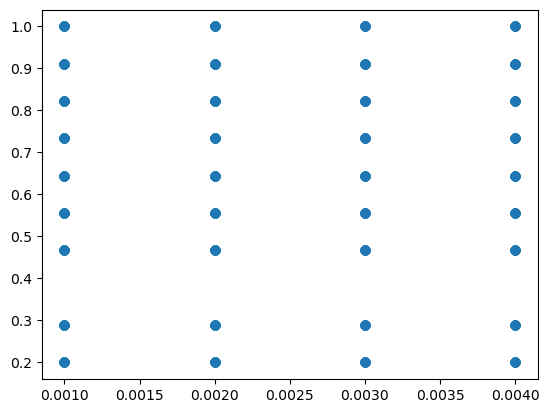

In [204]:
# plot the points of nc_k and sigma_k
grouped_df = df3.groupby(['NC_K','SIGMA_K']).count()
grouped_df = grouped_df[grouped_df.values > 7]
x = grouped_df.index.get_level_values('NC_K').to_numpy()
y = grouped_df.index.get_level_values('SIGMA_K').to_numpy()
plt.scatter(x, y)

In [205]:
for idx in range(grouped_df.shape[0]):
    row = grouped_df.iloc[idx]
    if row['NC_K'].isin(opt_nc) or row['SIGMA_K'].isin(opt_sigma):
        pass
    else:
        print(row)

KeyError: 'NC_K'

In [ ]:
df2 = df[-1*(df['NC_K'].isin(grid_nc))]

KeyError: "None of [Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\n            ...\n            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n           dtype='int64', length=3437)] are in the [columns]"

In [ ]:
n_unique = df['NC_K'].unique()
sigma_unique = df['SIGMA_K'].unique()
len(n_unique)

449

In [192]:
n_to_keep = []
for grid_point in n_unique:
    if grid_point not in grid_nc:
        n_to_keep.append(grid_point)
len(n_to_keep)

445

In [193]:

sigma_to_keep = []
for grid_point in sigma_unique:
    if grid_point not in grid_sigma:
        sigma_to_keep.append(grid_point)

In [206]:
df2

[Unnamed: 0         512
 Solvent          water
 FileHandle     0008noc
 NC_K          0.002472
 SIGMA_K       0.448381
                 ...   
 SS                 0.0
 TotalArea      243.846
 error        -0.004491
 error_ev     -0.000195
 error_frac   -0.001554
 Name: 512, Length: 67, dtype: object,
 Unnamed: 0         513
 Solvent          water
 FileHandle     0008noc
 NC_K          0.002442
 SIGMA_K        0.46585
                 ...   
 SS                 0.0
 TotalArea      243.846
 error         0.088902
 error_ev      0.003855
 error_frac    0.030762
 Name: 513, Length: 67, dtype: object,
 Unnamed: 0         514
 Solvent          water
 FileHandle     0008noc
 NC_K          0.002517
 SIGMA_K       0.419506
                 ...   
 SS                 0.0
 TotalArea      243.846
 error        -0.168678
 error_ev     -0.007315
 error_frac   -0.058366
 Name: 514, Length: 67, dtype: object,
 Unnamed: 0         515
 Solvent          water
 FileHandle     0008noc
 NC_K          0.00

In [207]:
df2 = df[(df['NC_K'].isin(n_to_keep)) & (df['SIGMA_K'].isin(sigma_to_keep))]
df2

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,OP,S,HS,OS,SP,SS,TotalArea,error,error_ev,error_frac
512,512,water,0008noc,0.002472,0.448381,0.000635,0.125520,-139.568960,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,-0.004491,-0.000195,-0.001554
513,513,water,0008noc,0.002442,0.465850,0.000624,0.121470,-139.573010,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,0.088902,0.003855,0.030762
514,514,water,0008noc,0.002517,0.419506,0.000655,0.132640,-139.561840,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,-0.168678,-0.007315,-0.058366
515,515,water,0008noc,0.002471,0.449172,0.000635,0.125330,-139.569150,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,-0.000110,-0.000005,-0.000038
516,516,water,0008noc,0.002491,0.450552,0.000632,0.124000,-139.570480,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,243.846,0.030560,0.001325,0.010574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8799,8799,water,0053phe,0.002626,0.638958,0.000483,-0.287089,-82.972285,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.000272,0.000012,-0.000041
8800,8800,water,0053phe,0.002626,0.639090,0.000483,-0.287114,-82.972310,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.000849,0.000037,-0.000128
8801,8801,water,0053phe,0.002649,0.632227,0.000485,-0.285222,-82.970418,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,-0.042781,-0.001855,0.006462
8802,8802,water,0053phe,0.002626,0.639287,0.000483,-0.287213,-82.972409,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.003132,0.000136,-0.000473


In [ ]:
df2_grouped = df2.groupby(['NC_K','SIGMA_K, TAU']).count()
df2_grouped = df2_grouped[df2_grouped.values >= 7]
nc_k = df2_grouped.index.get_level_values('NC_K')
sigma_k = df2_grouped.index.get_level_values('SIGMA_K')
taus = df2_grouped.index.get_level_values('TAU')
df2 = df2[(df2['NC_K'].isin(nc_k)) & (df2['SIGMA_K'].isin(sigma_k)) & (df2['TAU'].isin(taus)) ]

KeyError: 'SIGMA_K, TAU'

In [190]:
df2 = df2[df2['SoluteName'].isin(names)]
df2['error'] = df2['error'].abs()
df2 = df2[(df2['NC_K'] > 0.0015) & (df2['NC_K'] < 0.004) & (df2['SIGMA_K'] < 1.0)]
print(df2)
df2_grouped = df2.groupby(['NC_K','SIGMA_K']).mean()['error']
x = df2_grouped.index.get_level_values('NC_K').to_numpy()
y = df2_grouped.index.get_level_values('SIGMA_K').to_numpy()

      Unnamed: 0 Solvent FileHandle      NC_K   SIGMA_K       TAU  \
512          512   water    0008noc  0.002472  0.448381  0.000635   
513          513   water    0008noc  0.002442  0.465850  0.000624   
514          514   water    0008noc  0.002517  0.419506  0.000655   
515          515   water    0008noc  0.002471  0.449172  0.000635   
516          516   water    0008noc  0.002491  0.450552  0.000632   
...          ...     ...        ...       ...       ...       ...   
8799        8799   water    0053phe  0.002626  0.638958  0.000483   
8800        8800   water    0053phe  0.002626  0.639090  0.000483   
8801        8801   water    0053phe  0.002649  0.632227  0.000485   
8802        8802   water    0053phe  0.002626  0.639287  0.000483   
8803        8803   water    0053phe  0.002665  0.605185  0.000509   

      Solvation_Energy  Total_Energy   No. SoluteName  ...   OP    S   HS  \
512           0.125520   -139.568960  2100   n-octane  ...  0.0  0.0  0.0   
513           0.1

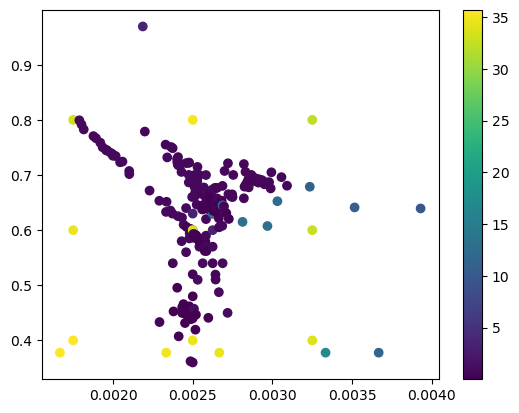

In [175]:
plt.scatter(x, y, c=df2_grouped.values)
plt.colorbar()

In [176]:
df3 = df2[df2['error'] < 2]


In [177]:

df3_grouped = df3.groupby(['NC_K','SIGMA_K','TAU']).mean()['error']
x = df3_grouped.index.get_level_values('NC_K').to_numpy()
y = df3_grouped.index.get_level_values('SIGMA_K').to_numpy()

(array([0.0015 , 0.00175, 0.002  , 0.00225, 0.0025 , 0.00275, 0.003  ,
        0.00325, 0.0035 , 0.00375, 0.004  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

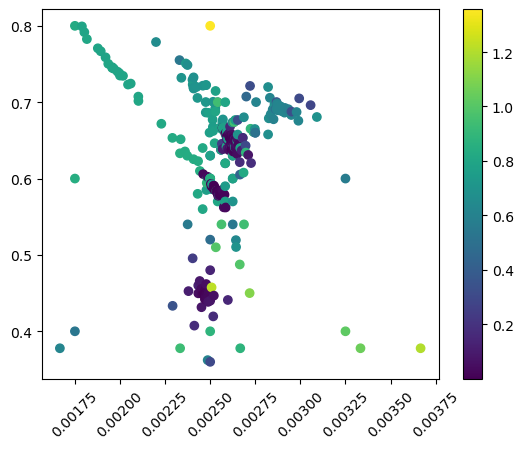

In [178]:
plt.scatter(x, y, c=df3_grouped.values)
plt.colorbar()
plt.xticks(rotation=45)

In [179]:
import plotly.express as px
plot_df = pd.DataFrame()
plot_df['x'] = df3_grouped.index.get_level_values('NC_K').to_numpy()

plot_df['y'] = df3_grouped.index.get_level_values('SIGMA_K').to_numpy()
plot_df['TAU'] = df3_grouped.index.get_level_values('TAU').to_numpy()
plot_df['error'] = df3_grouped.values
px.scatter(data_frame=plot_df,  x='x',y='y', color='error', hover_name='TAU')

In [152]:
nc_min = x[plot_df['error'].argmin()]
sigma_min = y[plot_df['error'].argmin()]
tau_min = plot_df['TAU'][plot_df['error'].argmin()]

In [153]:
nc_min, sigma_min, tau_min

(0.0025321952353131, 0.5848822239885582, 0.0005449878475288)

In [154]:
error_min = plot_df['error'][plot_df['error'].argmin()]
error_min

4.5419999864626526e-05

In [180]:
plot_df.value_counts

<bound method DataFrame.value_counts of             x         y       TAU     error
0    0.001667  0.377778  0.000525  0.616997
1    0.001750  0.400000  0.000525  0.532175
2    0.001750  0.600000  0.000525  0.845185
3    0.001750  0.800000  0.000525  0.824608
4    0.001789  0.799270  0.000624  0.792085
..        ...       ...       ...       ...
425  0.003091  0.680620  0.000983  0.690235
426  0.003250  0.400000  0.000525  1.019378
427  0.003250  0.600000  0.000525  0.562465
428  0.003333  0.377778  0.000525  1.053284
429  0.003667  0.377778  0.000525  1.201576

[430 rows x 4 columns]>

In [184]:
df3.groupby(['NC_K','SIGMA_K','TAU']).count().values.min()

1

In [1]:
import numpy as np

In [13]:
epsilon_r = 78.36 # relative permittivity of water
k = 1.38064852e-23 # Boltzmann constant in J/K
T = 298.15 # Kelvin
epsilon_0 = 8.85418782e-12 # absolute permittivity of free space in F/m
epsilon = epsilon_r * epsilon_0
e = 1.60217662e-19 # Charge of electron
c_0 = 0.003 # moles/L
z = 1 # charge of ion
c_0 = c_0 * 6.02214076e26 # atoms/mole
debye_length = np.sqrt((epsilon*k*T)/(2*(e**2)*(z**2)*c_0))/1e-10 # in Angstroms
debye_length

55.490557123869856